In [1]:
import flappy_bird_gymnasium
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import gym
from gym import spaces
import pygame
import random
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback


In [2]:
number_episodes= 500000

# Basis Environment

In [3]:
class FlappyBirdEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self):
        super(FlappyBirdEnv, self).__init__()
        self.screen_width = 288
        self.screen_height = 512
        self.pipe_gap = 200
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.gravity = 1
        self.jump_strength = -10
        self.pipe_width = 50
        self.pipe_velocity = -5
        
        self.action_space = spaces.Discrete(2)  # 0: No flap, 1: Flap
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0, 0], dtype=np.float32),
            high=np.array([self.screen_width, self.screen_height, self.screen_width, self.screen_height], dtype=np.float32)
        )
        
        self.screen = None
        self.clock = None
        self.done = False
        self.bird_vel_y = 0
        self.score = 0
        self.pipes = []
        self.passed_pipes = 0
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)  # Seed wird gesetzt
        self.bird_y = self.screen_height // 2
        self.bird_x = self.screen_width // 4
        self.bird_vel_y = 0
        self.done = False
        self.score = 0
        self.pipes = [self._create_pipe()]
        self.passed_pipes = 0
        return self._get_observation(), {}
    
    def step(self, action):
        if action == 1:
            self.bird_vel_y = self.jump_strength
        self.bird_vel_y += self.gravity
        self.bird_y += self.bird_vel_y
        
        if self.bird_y < 0:
            self.bird_y = 0
            self.done = True
        if self.bird_y > self.screen_height:
            self.bird_y = self.screen_height
            self.done = True
        
        self._move_pipes()
        self._check_collision()
        
        reward = 0
        # Überprüfe, ob der Vogel eine Pipe passiert hat
        if self._passed_pipe():
            reward = 1
            self.passed_pipes += 1  # Zählen der durchflogenen Pipes
        if self.done:
            reward = -100
        
        observation = self._get_observation()
        info = {'pipe_count': self.passed_pipes}  # Anzahl der durchflogenen Pipes
        return observation, reward, self.done, False, info
    
    def render(self, mode='human'):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((self.screen_width, self.screen_height))
            self.clock = pygame.time.Clock()
        
        self.screen.fill((0, 0, 255))
        pygame.draw.circle(self.screen, (255, 255, 0), (self.bird_x, self.bird_y), 20)
        
        for pipe in self.pipes:
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['top'])
            pygame.draw.rect(self.screen, (0, 255, 0), pipe['bottom'])
        
        pygame.display.flip()
        self.clock.tick(30)
    
    def close(self):
        if self.screen is not None:
            pygame.quit()
            self.screen = None
    
    def _create_pipe(self):
        gap_start = random.randint(0, self.screen_height - self.pipe_gap)
        top_rect = pygame.Rect(self.screen_width, 0, self.pipe_width, gap_start)
        bottom_rect = pygame.Rect(self.screen_width, gap_start + self.pipe_gap, self.pipe_width, self.screen_height)
        return {'top': top_rect, 'bottom': bottom_rect, 'passed': False}
    
    def _move_pipes(self):
        for pipe in self.pipes:
            pipe['top'].x += self.pipe_velocity
            pipe['bottom'].x += self.pipe_velocity
        
        if self.pipes[0]['top'].x < -self.pipe_width:
            self.pipes.pop(0)
            self.pipes.append(self._create_pipe())
            self.score += 1
    
    def _check_collision(self):
        if self.bird_y >= self.screen_height or self.bird_y <= 0:
            self.done = True
        
        bird_rect = pygame.Rect(self.bird_x, self.bird_y, 20, 20)
        for pipe in self.pipes:
            if bird_rect.colliderect(pipe['top']) or bird_rect.colliderect(pipe['bottom']):
                self.done = True
    
    def _get_observation(self):
        pipe = self.pipes[0]
        return np.array([self.bird_x, self.bird_y, pipe['top'].x, pipe['top'].bottom], dtype=np.float32)

    def _passed_pipe(self):
        for pipe in self.pipes:
            if not pipe['passed'] and pipe['top'].x < self.bird_x:
                pipe['passed'] = True
                return True
        return False

# Überprüfe die Umgebung
env = FlappyBirdEnv()
check_env(env, warn=True)

# Q-Learning

## Registrieren der Environment

In [4]:
# Registrierung der Umgebung
gym.envs.registration.register(
    id='FlappyBird-v0',
    entry_point=FlappyBirdEnv,
    max_episode_steps=1000,
)

# Verwendung der benutzerdefinierten Umgebung
env = gym.make('FlappyBird-v0')

c:\Users\Katha\anaconda3\envs\RL\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment FlappyBird-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [5]:
# Reset der Umgebung
state, _ = env.reset()

# Render der Umgebung
done = False
while not done:
    action = env.action_space.sample()  # Zufällige Aktion
    state, reward, done, truncated, info = env.step(action)
    env.render()

env.close()

c:\Users\Katha\anaconda3\envs\RL\Lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


## QLearning Agent

In [6]:
list_alpha = [0.01, 0.5]
list_gamma = [0.9, 1]
list_epsilon =[0.01,0.2]
class metrics:
    liste = []
    standard = 0
    name = ""
Alpha = metrics
Alpha.liste = [0.01, 0.5]
Alpha.standard = 0.1
Alpha.name = "alpha"
Gamma = metrics
Gamma.liste= [0.9, 0.99]
Gamma.standard = 0.99
Gamma.name = "gamma"
Epsilon = metrics
Epsilon.liste= [0.01,0.2]
Epsilon.standard = 0.1
Epsilon.name = "epsilon"

In [7]:
class QLearningAgent:
    def __init__(self, state_bins, num_actions, alpha=Alpha.standard, gamma= Gamma.standard, epsilon=Epsilon.standard, observation_space=None):
        self.state_bins = state_bins
        self.num_actions = num_actions
        self.alpha = alpha  # Lernrate
        self.gamma = gamma  # Diskontierungsfaktor
        self.epsilon = epsilon  # Epsilon für epsilon-greedy Policy
        self.q_table = np.zeros((*state_bins, num_actions))
        self.observation_space = observation_space

    def discretize(self, state):
        state_indices = []
        for i in range(len(state)):
            idx = np.digitize(state[i], np.linspace(0, self.observation_space.high[i], self.state_bins[i])) - 1
            state_indices.append(idx)
        return tuple(state_indices)

    def choose_action(self, state):
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(self.num_actions))  # Zufällige Aktion (explore)
        else:
            return np.argmax(self.q_table[state])  # Beste Aktion (exploit)

    def update(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.gamma * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.alpha * td_error

    def train(self, env, num_episodes):
        total_rewards = []
        pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                self.update(state, action, reward, next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)  # Zählen der Pipes aus dem Info-Dictionary
            total_rewards.append(episode_reward)
            pipes_passed.append(episode_pipes)
            #print(f"Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
        return total_rewards, pipes_passed
    def evaluate(self, env, num_episodes=10):
        evaluation_rewards = []
        evaluation_pipes_passed = []
        for episode in range(num_episodes):
            state, _ = env.reset()
            state = self.discretize(state)
            done = False
            episode_reward = 0
            episode_pipes = 0
            while not done:
                action = np.argmax(self.q_table[state])  # Beste Aktion basierend auf der Q-Tabelle wählen
                next_state, reward, done, truncated, info = env.step(action)
                next_state = self.discretize(next_state)
                state = next_state
                episode_reward += reward
                episode_pipes = info.get('pipe_count', episode_pipes)
            evaluation_rewards.append(episode_reward)
            evaluation_pipes_passed.append(episode_pipes)
            #print(f"Evaluation Episode {episode + 1}/{num_episodes} completed, Reward: {episode_reward}, Pipes Passed: {episode_pipes}")
        return evaluation_rewards, evaluation_pipes_passed
    def save(self, filename):
        np.save(filename, self.q_table)
        
    def load(self, filename):
        self.q_table = np.load(filename)


# Verwendung der benutzerdefinierten Umgebung
env = FlappyBirdEnv()
state_bins = (10, 10, 10, 10)  # Diskretisierung in 10 Bins pro Zustandsdimension
num_actions = env.action_space.n

agent = QLearningAgent(state_bins=state_bins, num_actions=num_actions, observation_space=env.observation_space)
rewards, pipes_passed = agent.train(env, num_episodes=number_episodes)


In [8]:
agent.save('models_qlearning/basis_')

In [10]:
#agent = QLearningAgent(state_bins=state_bins, num_actions=num_actions, observation_space=env.observation_space)
df_q_learing = pd.DataFrame()
#Alpha
# Beispiel für die Verwendung anderer Hyperparameter
for i in Alpha.liste:
    agent = QLearningAgent(
        state_bins=state_bins,
        num_actions=num_actions,
        alpha=i,
        gamma=Gamma.standard,
        epsilon=Epsilon.standard,
        observation_space=env.observation_space
    )

    nr_episodes = number_episodes  # Beispielwert für die Anzahl der Episoden
    rewards, pipes_passed = agent.train(env, num_episodes=nr_episodes)
    agent.save('models_qlearning/alpha_' + str(i))
    df_q_learing["alpha_rewards"+str(i)]=rewards
    df_q_learing["alpha_pipes"+str(i)]=pipes_passed
    

#Gamma
# Beispiel für die Verwendung anderer Hyperparameter
for i in Gamma.liste:
    agent = QLearningAgent(
        state_bins=state_bins,
        num_actions=num_actions,
        alpha=Alpha.standard,
        gamma=i,
        epsilon=Epsilon.standard,
        observation_space=env.observation_space
    )

    nr_episodes = number_episodes  # Beispielwert für die Anzahl der Episoden
    rewards, pipes_passed = agent.train(env, num_episodes=nr_episodes)
    agent.save('models_qlearning/gamma_' + str(i))
    df_q_learing["gamma_rewards"+str(i)]=rewards
    df_q_learing["gamma_pipes"+str(i)]=pipes_passed


    

#Epsilon
# Beispiel für die Verwendung anderer Hyperparameter
for i in Epsilon.liste:
    agent = QLearningAgent(
        state_bins=state_bins,
        num_actions=num_actions,
        alpha=Alpha.standard,
        gamma=Gamma.standard,
        epsilon=i,
        observation_space=env.observation_space
    )

    nr_episodes = number_episodes  # Beispielwert für die Anzahl der Episoden
    rewards, pipes_passed = agent.train(env, num_episodes=nr_episodes)
    agent.save('models_qlearning/epsilon_' + str(i))
    df_q_learing["epsilon_rewards"+str(i)]=rewards
    df_q_learing["epsilon_pipes"+str(i)]=pipes_passed

    


In [11]:
df_q_learing.to_csv("models_qlearning.train_progress.csv")


In [12]:
# Modell laden und evaluieren
agent.load('models_qlearning/q_table.npy')
eval_rewards, eval_pipes_passed = agent.evaluate(env)

print(f"Evaluation Rewards: {eval_rewards}")
print(f"Evaluation Pipes Passed: {eval_pipes_passed}")

FileNotFoundError: [Errno 2] No such file or directory: 'models_qlearning/q_table.npy'

## Plotten des Rewards

    Reward  Pipes  Index
81     -97      3     81


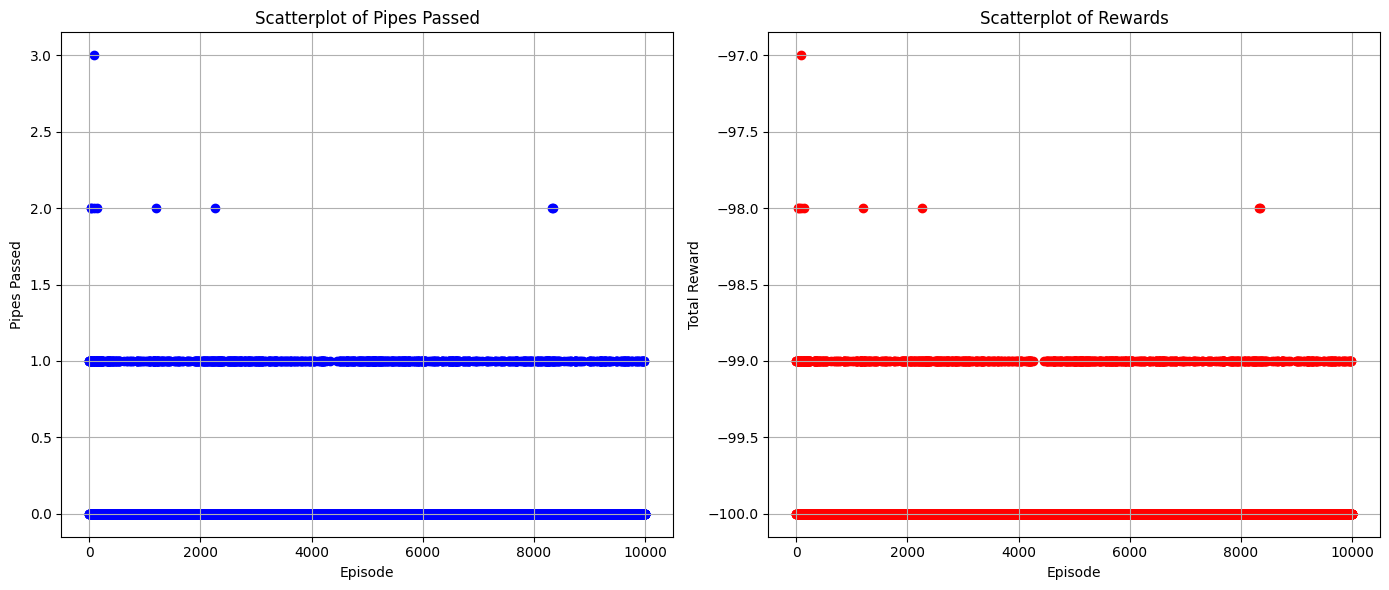

In [ ]:
df = pd.DataFrame({"Reward": rewards, "Pipes": pipes_passed})
df["Index"] = df.index

df["Pipes"].max()
print(df.loc[df["Pipes"]==df["Pipes"].max()])

# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Modell anwenden und die Umgebung rendern
state, _ = env.reset()
state = agent.discretize(state)

done = False
while not done:
    action = agent.choose_action(state)
    next_state, reward, done, truncated, info = env.step(action)
    next_state = agent.discretize(next_state)
    env.render()
    state = next_state

env.close()

## Rewards des Testen

In [ ]:
# Nach dem Training das Modell 10 Mal evaluieren
evaluation_rewards, evaluation_pipes_passed = agent.evaluate(env, num_episodes=10)

# Ergebnisse in einer Liste speichern
results = list(zip(evaluation_rewards, evaluation_pipes_passed))

Evaluation Episode 1/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 2/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 3/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 4/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 5/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 6/10 completed, Reward: -99, Pipes Passed: 1
Evaluation Episode 7/10 completed, Reward: -99, Pipes Passed: 1
Evaluation Episode 8/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 9/10 completed, Reward: -100, Pipes Passed: 0
Evaluation Episode 10/10 completed, Reward: -100, Pipes Passed: 0


   Reward  Pipes  Index
5     -99      1      5
6     -99      1      6


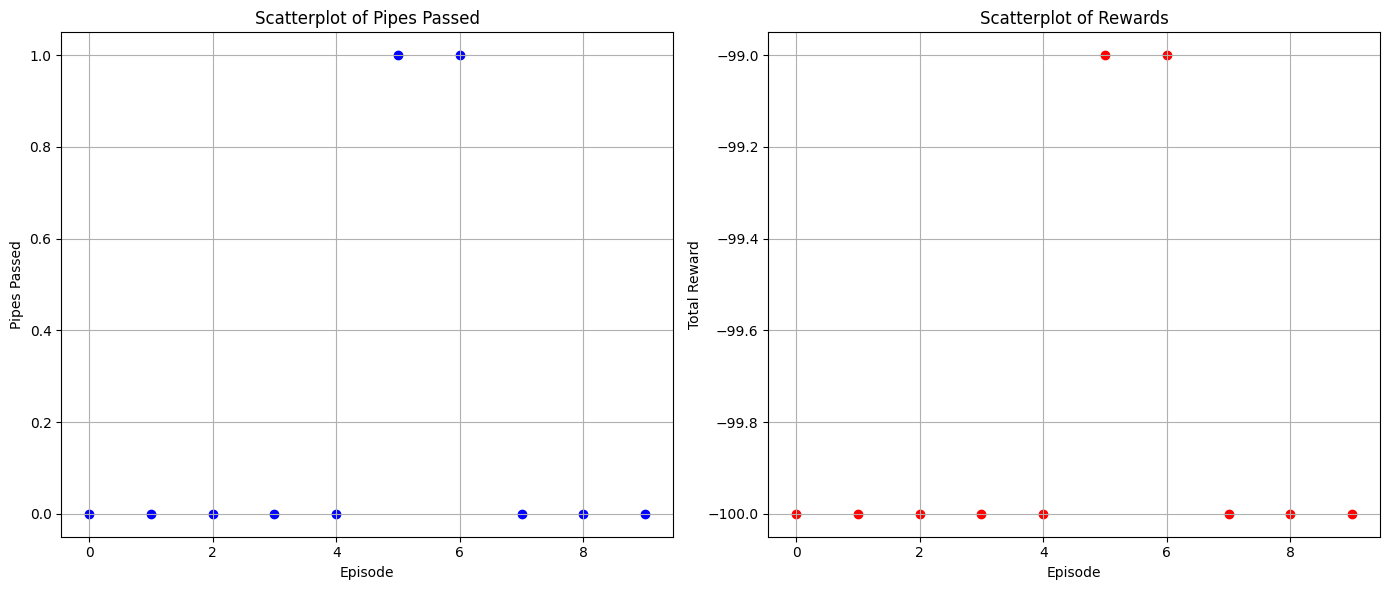

In [ ]:
df = pd.DataFrame({"Reward": evaluation_rewards, "Pipes": evaluation_pipes_passed})
df["Index"] = df.index

df["Pipes"].max()
print(df.loc[df["Pipes"]==df["Pipes"].max()])

# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

# PPO

## Erstellen des Modells

In [ ]:
class RewardPipeCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardPipeCallback, self).__init__(verbose)
        self.rewards = []
        self.pipe_counts = []
    
    def _on_step(self) -> bool:
        self.rewards.append(self.locals['rewards'])
        self.pipe_counts.append(self.locals['infos'][0]['pipe_count'])
        return True
    
    def _on_training_end(self) -> None:
        # Save the collected rewards and pipe counts to instance variables
        self.model.rewards = self.rewards
        self.model.pipe_counts = self.pipe_counts

# Überprüfe die Umgebung
env = FlappyBirdEnv()

# Erstelle den Callback
reward_pipe_callback = RewardPipeCallback()

# Trainiere den PPO Algorithmus mit dem Callback
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=number_episodes, callback=reward_pipe_callback)

# Speichere das trainierte Modell
model.save("ppo_flappybird")

# Lade das Modell und teste es
model = PPO.load("ppo_flappybird")

# Jetzt kannst du die gesammelten Belohnungen und Pipe-Zählungen nach dem Training auslesen
rewards = model.rewards
pipe_counts = model.pipe_counts

print(f"Gesammelte Belohnungen: {rewards}")
print(f"Gesammelte Pipe-Zählungen: {pipe_counts}")

episodes = 10  # Anzahl der Episoden zum Testen
pipe_counts_per_episode = []
list_rewards = []

for episode in range(episodes):
    obs = env.reset()[0]  # Extrahiere die Beobachtung aus dem Tuple
    total_pipes = 0
    total_reward = 0  # Summe der Belohnungen für diese Episode
    done = False
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, _, info = env.step(action)
        obs = obs  # Keine Extraktion mehr notwendig
        env.render()
        total_reward += reward  # Summiere die Belohnungen
        total_pipes = info['pipe_count']
    pipe_counts_per_episode.append(total_pipes)
    list_rewards.append(total_reward)  # Speichere die gesamte Belohnung
    print(f"Episode {episode + 1} beendet. Durchflogene Pipes: {total_pipes}, Belohnung: {total_reward}")

env.close()

print(f"Durchflogene Pipes pro Episode: {pipe_counts_per_episode}")
print(f"Belohnungen pro Episode: {list_rewards}")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.3     |
|    ep_rew_mean     | -100     |
| time/              |          |
|    fps             | 1811     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 34.6        |
|    ep_rew_mean          | -100        |
| time/                   |             |
|    fps                  | 1090        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015006971 |
|    clip_fraction        | 0.0395      |
|    clip_range           | 0.2         |
|    entropy_loss   

In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
import numpy as np

class RewardPipeCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardPipeCallback, self).__init__(verbose)
        self.rewards = []
        self.pipe_counts = []
    
    def _on_step(self) -> bool:
        self.rewards.append(self.locals['rewards'])
        if 'pipe_count' in self.locals['infos'][0]:
            self.pipe_counts.append(self.locals['infos'][0]['pipe_count'])
        else:
            self.pipe_counts.append(0)  # Oder eine andere Standardwert, falls pipe_count fehlt
        return True
    
    def _on_training_end(self) -> None:
        # Save the collected rewards and pipe counts to instance variables
        self.model.rewards = self.rewards
        self.model.pipe_counts = self.pipe_counts

# Überprüfe die Umgebung
env = FlappyBirdEnv()

# Erstelle den Callback
reward_pipe_callback = RewardPipeCallback()

# Trainiere den PPO Algorithmus mit dem Callback
model = PPO('MlpPolicy', env, verbose=1)
model.learn(total_timesteps=number_episodes, callback=reward_pipe_callback)

# Speichere das trainierte Modell
model.save("ppo_flappybird")

# Lade das Modell und teste es
model = PPO.load("ppo_flappybird")

# Jetzt kannst du die gesammelten Belohnungen und Pipe-Zählungen nach dem Training auslesen
rewards = model.rewards
pipe_counts = model.pipe_counts

print(f"Gesammelte Belohnungen: {rewards}")
print(f"Gesammelte Pipe-Zählungen: {pipe_counts}")

episodes = 10  # Anzahl der Episoden zum Testen
pipe_counts_per_episode = []
list_rewards = []

for episode in range(episodes):
    obs = env.reset()  # Extrahiere die Beobachtung aus dem Tuple
    total_pipes = 0
    total_reward = 0  # Summe der Belohnungen für diese Episode
    done = False
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, _, info = env.step(action)
        env.render()
        total_reward += reward  # Summiere die Belohnungen
        total_pipes = info['pipe_count'] if 'pipe_count' in info else total_pipes  # Aktualisiere nur, wenn vorhanden
    pipe_counts_per_episode.append(total_pipes)
    list_rewards.append(total_reward)  # Speichere die gesamte Belohnung
    print(f"Episode {episode + 1} beendet. Durchflogene Pipes: {total_pipes}, Belohnung: {total_reward}")

env.close()

print(f"Durchflogene Pipes pro Episode: {pipe_counts_per_episode}")
print(f"Belohnungen pro Episode: {list_rewards}")


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 33.3     |
|    ep_rew_mean     | -100     |
| time/              |          |
|    fps             | 1790     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 32.6        |
|    ep_rew_mean          | -100        |
| time/                   |             |
|    fps                  | 1134        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011611191 |
|    clip_fraction        | 0.0247      |
|    clip_range           | 0.2         |
|    entropy_loss   

ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api

## Plotten des Reward des Trainings

In [ ]:
print(f"Gesammelte Belohnungen: {rewards}")
print(f"Gesammelte Pipe-Zählungen: {pipe_counts}")

Gesammelte Belohnungen: [array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([0.], dtype=float32), array([-100.], dtype=fl

       Reward  Pipes  Index
15094     1.0      2  15094
15095     0.0      2  15095
15096     0.0      2  15096
15097     0.0      2  15097
15098     0.0      2  15098
...       ...    ...    ...
30309     0.0      2  30309
30310     0.0      2  30310
30311     0.0      2  30311
30312     0.0      2  30312
30313  -100.0      2  30313

[308 rows x 3 columns]


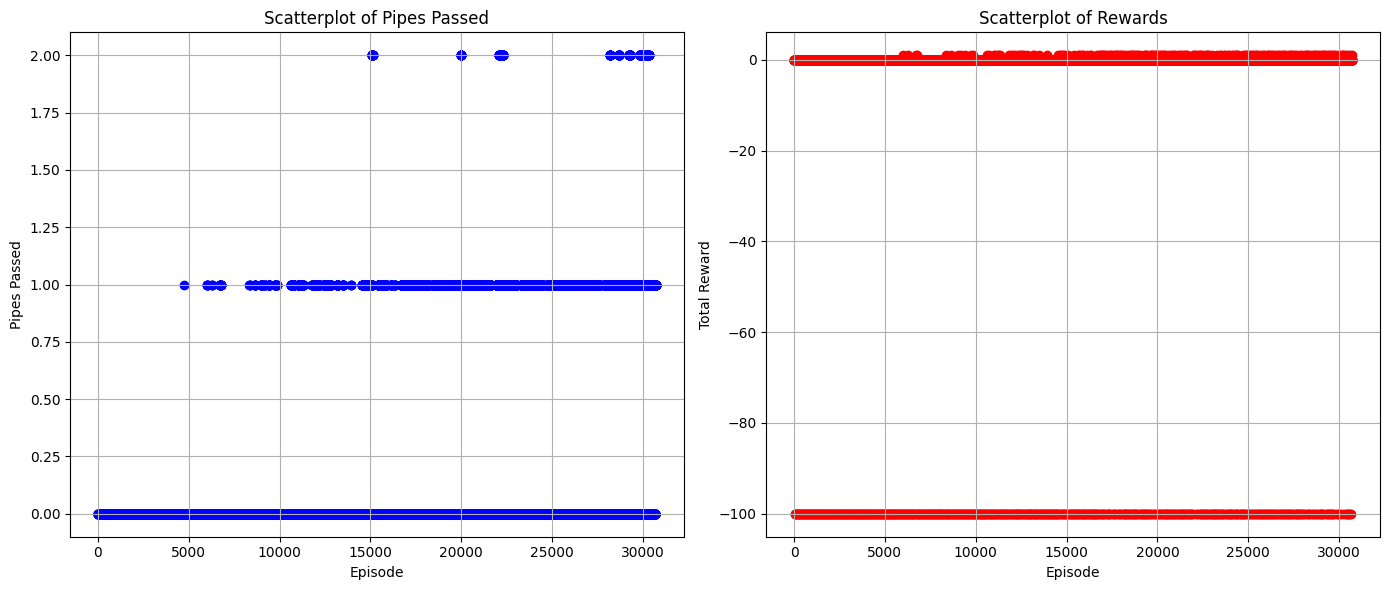

In [ ]:
rewards[1][0]
list_train_rewards = []
for i in range(0,len(rewards)):
    list_train_rewards.append(rewards[i][0])

df = pd.DataFrame({"Reward": list_train_rewards, "Pipes": pipe_counts})
df["Index"] = df.index

df["Pipes"].max()
print(df.loc[df["Pipes"]==df["Pipes"].max()])

# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

## Plotten des Rewards des Tests

   Reward  Pipes  Index
3     -98      2      3


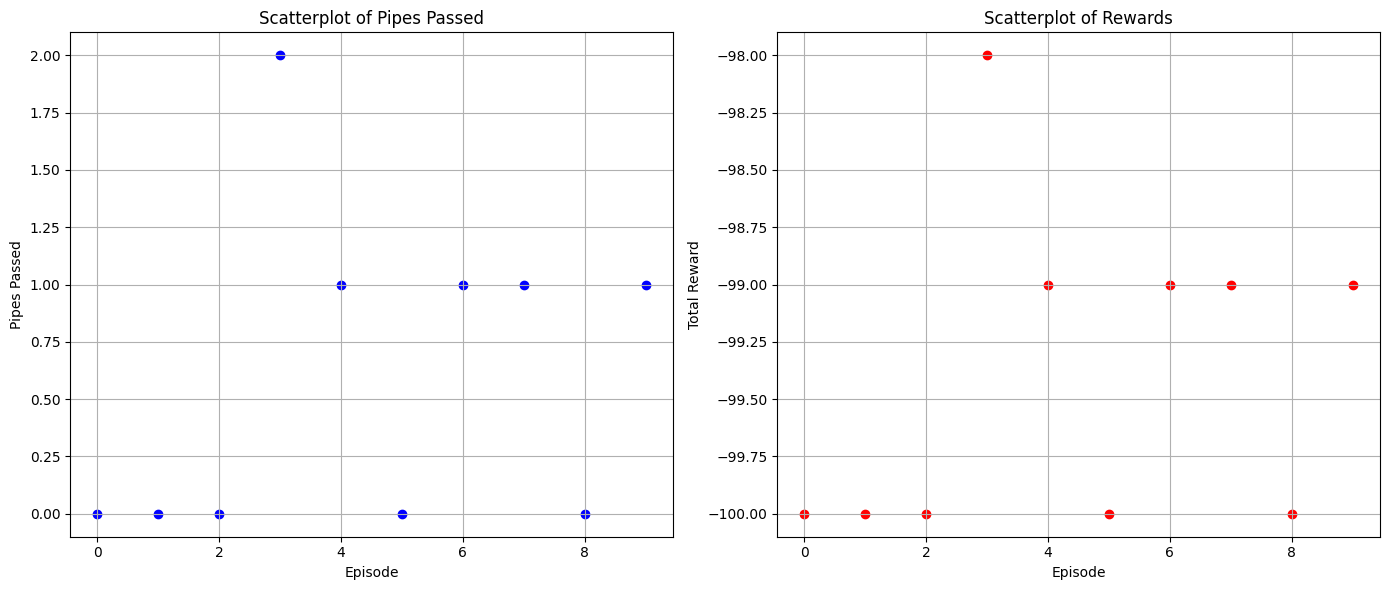

In [ ]:
df = pd.DataFrame({"Reward": list_rewards, "Pipes": pipe_counts_per_episode})
df["Index"] = df.index

df["Pipes"].max()
print(df.loc[df["Pipes"]==df["Pipes"].max()])

# Scatterplots erstellen
plt.figure(figsize=(14, 6))

# Scatterplot für Pipes
plt.subplot(1, 2, 1)
plt.scatter(df['Index'], df['Pipes'], color='blue')
plt.title('Scatterplot of Pipes Passed')
plt.xlabel('Episode')
plt.ylabel('Pipes Passed')
plt.grid(True)

# Scatterplot für Rewards
plt.subplot(1, 2, 2)
plt.scatter(df['Index'], df['Reward'], color='red')
plt.title('Scatterplot of Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)

plt.tight_layout()
plt.show()

# Baseline

In [ ]:
# Definiere die Heuristikfunktion
def heuristic(obs):
    bird_y = obs[1]
    threshold = 0.4 * 512  # 40% der Bildschirmhöhe
    return 1 if bird_y > threshold else 0

# Variablen zur Verfolgung des Fortschritts
total_timesteps = 20000
current_total_timesteps = 0
ep_rew_sum = 0
episode_rewards = []
episode_lengths = []

# Umgebung initialisieren
env = FlappyBirdEnv()
obs, _ = env.reset()

while current_total_timesteps < total_timesteps:
    action = heuristic(obs)
    obs, reward, terminated, _, _ = env.step(action)
    ep_rew_sum += reward
    current_total_timesteps += 1

    if terminated:
        episode_rewards.append(ep_rew_sum)
        episode_lengths.append(current_total_timesteps)
        obs, _ = env.reset()
        ep_rew_sum = 0

        # Fortschritt alle 100 Episoden protokollieren
        if len(episode_rewards) % 100 == 0:
            mean_reward = np.mean(episode_rewards[-100:])
            print(f"Episode: {len(episode_rewards)}, Total Timesteps: {current_total_timesteps}, Mean Reward (last 100 episodes): {mean_reward}")

# Umgebung schließen
env.close()

# Kumulative Timesteps und mittlere Rewards berechnen
cumulative_timesteps = np.cumsum(episode_lengths)
mean_rewards = [np.mean(episode_rewards[:i+1]) for i in range(len(episode_rewards))]

# Ergebnisse in ein DataFrame speichern
results_df = pd.DataFrame({
    'total_timesteps': cumulative_timesteps,
    'ep_rew_mean': mean_rewards
})

# Ergebnisse in eine Datei protokollieren
log_dir = "./logs/baseline_rew100_2Mio"
os.makedirs(log_dir, exist_ok=True)
baseline_log_file = os.path.join(log_dir, "progress.csv")
results_df.to_csv(baseline_log_file, index=False)

print(f"Results saved to {baseline_log_file}")

Episode: 100, Total Timesteps: 10078, Mean Reward (last 100 episodes): -98.96
Episode: 200, Total Timesteps: 19803, Mean Reward (last 100 episodes): -99.08


NameError: name 'os' is not defined